In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import pandas as pd
import numpy as np
import os


from models.CNNModels import ResNet,CondensedAlexNet,CondensedGoogLeNet
from models.training import get_confusion_matrix,train_model
from data.data_processing import DataHandler,get_training_data_from_path
from backtest.backtest import Backtester

from config.config import GoogleNet_hyperparams,AlexNet_hyperparams, ResNet_hyperparams

%load_ext autoreload
%autoreload 2
%matplotlib inline

folder_for_samples = 'data/cnn_samples'

# Data Processing

## Get stock data in Handler object
+ See full description of data processing parameters in DataHandler docstring

+ ### When running the code do take into account that using all data will take a long time to process
    + if you want to reduce the total size you can:
        + reduce frac of stocks (recommended), frac of 1. will consider all stocks
        + increase minimum_volume
        + change the boundary dates

In [70]:
path_to_dump_samples = os.path.join(folder_for_samples,'regular')
# path_to_dump_samples = os.path.join(folder_for_samples,'close-1_week-2015_2018-64_pixels-high_VOL')

handler = DataHandler(encoding_method='GADF', window_len=42, image_size=42, retrain_freq=5,  # For encoding images
                      start_date = 20100101, end_date= 20200101, frac_of_stocks=0.01,minimum_volume=2e6, # Filtering stocks and dates
                      stock_data_dir_path= 'data/2019_2010_stock_data', # Sources of the data: pickles on disk
                      dir_for_samples=path_to_dump_samples, nb_of_stocks_by_file=100) # About dumping Data Processing results on disk as pickles

In [71]:
handler.get_df_data()

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

#### Optionnal
Plots a heatmap of a timeseries encoded into an image

### Showing encoded images with method GADF for the stock 91673 between 20181030 and 20181231 

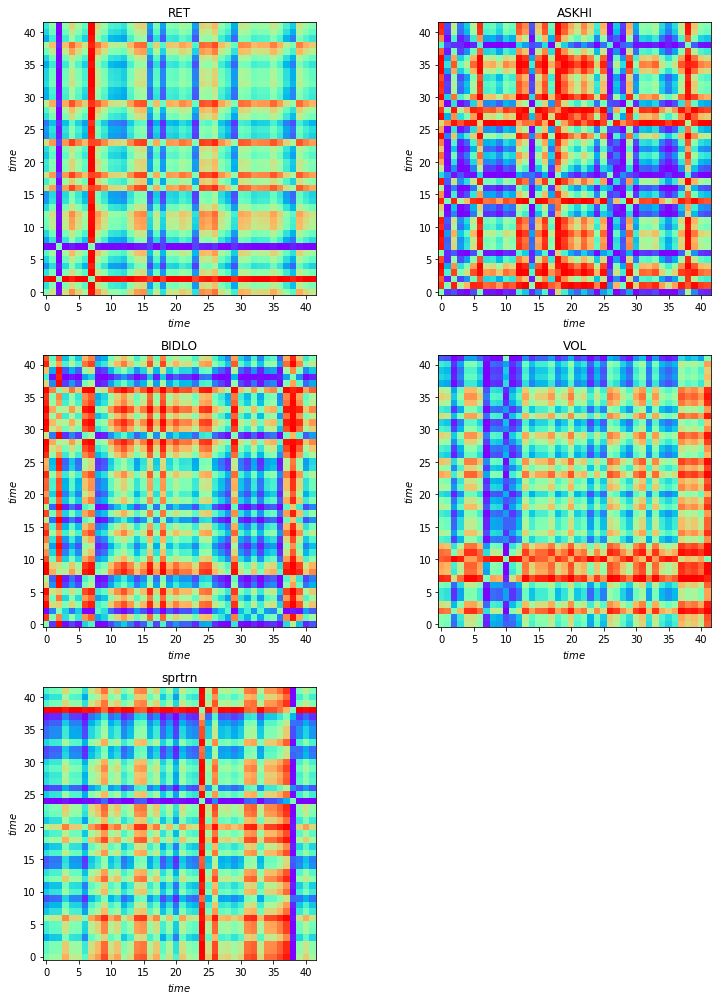

In [72]:
handler.show_multichannels_images()

## Builds images and targets and creates pickles
+ Be careful for the folder name (specified in handler object as dir_for_samples), this function will delete all files in this folder before dumping pickles

In [30]:
handler.build_and_dump_images_and_targets()

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

MemoryError: 

# Training

## Retrieve data from the specified folder
+ '/regular' is the default to retrieve samples, '/close-1_week-2015_2018-64_pixels-high_VOL' is another one
+ Choose train/val/test size

In [2]:
path_to_retrieve_samples = folder_for_samples+'/regular'
# path_to_retrieve_samples = folder_for_samples+'/close-1_week-2015_2018-64_pixels-high_VOL'

X_train, X_val, X_test, Y_train, Y_val, Y_test = get_training_data_from_path(samples_path=path_to_retrieve_samples,
                                targets_type='close',
                                train_val_size=2 / 3.,
                                train_size=0.75,
                                logger_env='Training')

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

EOFError: Ran out of input

## Build the neural network object and Train the network 

+ Choose your parameters,
    + Cost matrix
    + Where to save the checkpoints
    + If you run restore = True Choose the checkpoint.meta file to use for the model to load

In [11]:
# penalty factor assigned for misclassifying i to j. It used to combine sample prior (distribution of classes in the training
# sample) to compute expected penalty of misclassifying i-th class
cost_matrix=np.array([[0, 1.1, 1.4], [1.1, 0, 1.1], [1.4, 1.1, 0]])

# Path where to drop the checkpoints files saved during training
checkpoints_folder = 'model_checkpoints'
checkpoint_prefix = 'ckpt-close-1_week-2015_2018-64_pixels-high_VOL_cost_sensitive'
model_checkpoints_path = os.path.join(checkpoints_folder,checkpoint_prefix)

# if we want to restore a model in order to train it even more (uncomment second line to take the latest)
path_restore  = 'model_checkpoints/ckpt-close-1_week-2010_2018-42_pixels-medium_VOL-GoogLeNet-.meta'
# path_restore = (tf.train.latest_checkpoint('model_checkpoints') or '')+'.meta'


# Only considers a fraction of the data, useful for test purposes and because training is really long
frac = 1.
X_train1, X_val1, Y_train1, Y_val1 =  X_train[int((1-frac)*n_train):], X_val[int((1-frac)*n_val):], Y_train[int((1-frac)*n_train):], Y_val[int((1-frac)*n_val):]

### Choose which network to use
+ Uncomment the one you want to use
+ To modify hyperparameters use .update and specify changes (model is given in config.py)

In [12]:
shape_x,shape_y = list(X_train.shape),list(Y_train.shape)
shape_x[0],shape_y[0] = None,None


######## GoogLeNet
# GoogleNet_hyperparams.update({})
network = CondensedGoogLeNet(shape_x=shape_x,shape_y=shape_y,hyperparams=GoogleNet_hyperparams)

######## ResNet
# ResNet_hyperparams.update( {'learning_rate':0.003,'tf_optimizer':'rmsprop','dropout':0.1})
# network = ResNet(shape_x=shape_x,shape_y=shape_y,hyperparams=ResNet_hyperparams)

######## AlexNet
# AlexNet_hyperparams.update({'learning_rate':0.003,'tf_optimizer':'adam','dropout':0.1})
# network = CondensedAlexNet(shape_x=shape_x,shape_y=shape_y,hyperparams=AlexNet_hyperparams)

#### Run the training
+ See train_model docstring for extensive details

In [13]:
pred, training_loss,val_loss = train_model(X=X_train1, Y=Y_train1, batch_size=30, valX=X_val1, valY=Y_val1,
                                                       model_ckpt_path=model_checkpoints_path,cost_matrix=cost_matrix,
                                                       epochs=5, net=network,save_step =1,cost_sensitive_loss=True,restore=False,
                                                       model_ckpt_path_to_restore=path_restore)

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

# Backtest
+ Enter the checkpoint file path to use in order to make predictions
+ Enter the data file path to unpickle the samples and the returns in order to make a backtest. It should be the same folder as the one used to train the model in checkpoint path
+ Enter all strategies to test as a list of strings (See Backtester docstring for more details)

+ Then choose additionnal parameters for Backtester object:
    + start_date and end_date for boundary dates. The first date should be after the last date used for the training set
    + num_bins must be specified when we use "bins" strategies: i.e when we consider a ranking among all stocks and that we backtest strategies corresponding to each quantile of the stocks. Then num_bins is the number of separation we want. Use 10 if you want to consider 10 bins (The first one would be the strategies that goes long the best predicted 1/10th of the stocks)
    + network_name: either CondensedGoogLeNet CondensedAlexNet or ResNet

In [6]:
# to retrieve model
checkpoints_folder = 'model_checkpoints'
checkpoint_prefix = 'ckpt-close-1_week-2010_2018-42_pixels-medium_VOL'
model_checkpoints_path = os.path.join(checkpoints_folder,checkpoint_prefix)
model_checkpoints_path_file = model_checkpoints_path+'-84242.meta'


# to retrieve data
# path_to_retrieve_samples = folder_for_samples+'/close-1_week-2015_2018-64_pixels-high_VOL'
path_to_retrieve_samples = folder_for_samples+'/regular'

# strategies to test
num_bins = 7
strategies = ['10_max_long', '20_max_long', '2_max_long']+['{}_bins_long'.format(i) for i in range(1,num_bins+1)]+['{}_bins_long_short'.format(i) for i in range(1,num_bins+1)]

backtester = Backtester(path_data=path_to_retrieve_samples,
                        path_model_to_restore=model_checkpoints_path_file,
                        strategies = strategies, num_bins = num_bins,
                        start_date=20151001,end_date=20200101,
                        network_name='CondensedGoogLeNet'
                       )

In [7]:
backtester.run_backtest()

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

INFO:tensorflow:Restoring parameters from model_checkpoints\ckpt-close-1_week-2010_2018-42_pixels-medium_VOL-84242


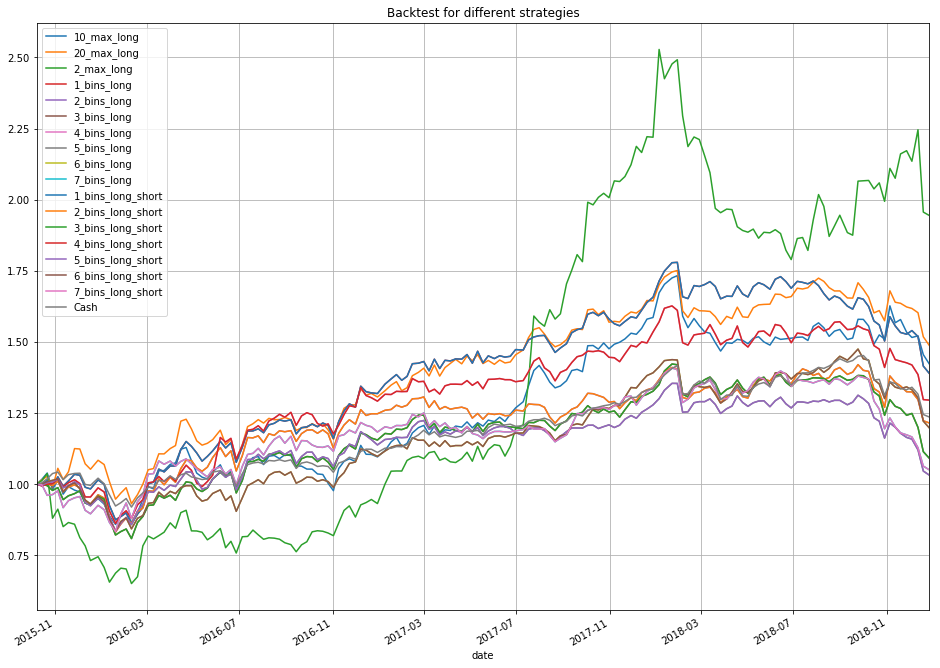

In [62]:
backtester.plot_backtest()

### In case of "bins" strategies
+ The following code will:
    + Plot the corresponding paths
    + Plot the average of the rankings of each quantile strategy (It should be exactly the identity function in the perfect case)

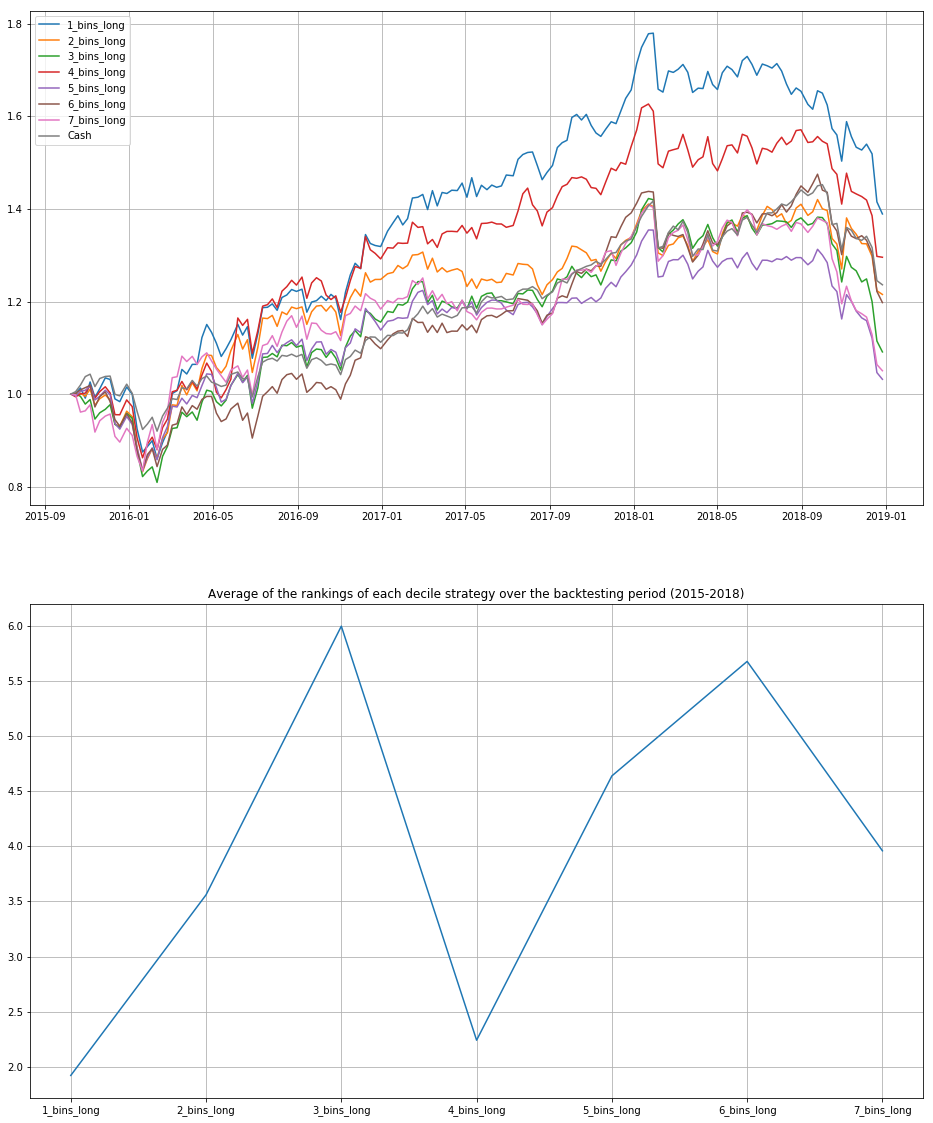

In [60]:
import matplotlib.pyplot as plt

def plot_bins(df_strats,ranking='long'):
    # ranking must be 'long' or 'long_short'
    df = df_strats[['{}_bins_{}'.format(i,ranking) for i in range(1,8)]+['Cash']]
    
    plt.figure(figsize=(16,20))
    plt.subplot(211)
    plt.plot(df)
    plt.grid()
    plt.legend(df.columns)

    plt.subplot(212)
    df_rank = df.drop(['Cash'],axis=1).rank(axis=1,ascending=False)[:50].mean()
    plt.plot(df_rank)
    plt.grid()
    plt.title('Average of the rankings of each quantile strategy over the backtesting period (2015-2018)')
    

plot_bins(backtester.df_strats,'long') # ranking 'long_short' is usually quite similar